In [1]:
import torch
from torch.autograd import Variable
print(f'Pytorch version {torch.__version__}')

import numpy as np
import pandas as pd
import seaborn as sns
import sys
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import distributions

from time import time
import re
import json

import os
import sys
import itertools
sys.path.append('/Users/ioanaciuca/Desktop/Normalizing_flows/DeepSpectra/')

import torch.optim as optim

from nflib.spline_flows import NSF_CL
from nflib.flows import (
    AffineConstantFlow,
    ActNorm,
    Invertible1x1Conv,
    NormalizingFlow,
    NormalizingFlowModel,
)

device='cpu'


import random

random.seed(0)

%matplotlib inline

Pytorch version 1.7.1


In [2]:
df = pd.read_csv("/Users/ioanaciuca/Desktop/hephaestusaiLight/cache/Canaletto/Reduced_l_scattering_fixed_pix_0_25mm10_4_2048_df_rgb0.csv")
df.head()

,Coeff_0,Coeff_1,Coeff_2,Coeff_3,Coeff_4,Coeff_5,Coeff_6,Coeff_7,Coeff_8,Coeff_9,...,Coeff_48,Coeff_49,Coeff_50,Coeff_51,Coeff_52,Coeff_53,Coeff_54,target_names,class_labels,img_names
0,0.341056,0.236373,0.208636,0.217799,0.255938,0.305922,0.381264,0.439587,0.595356,0.853179,...,0.046917,0.063164,0.058683,0.057722,0.070341,0.060843,0.085134,canaletto,1,VerticalFlip_NG_Canaletto_05
1,0.115522,0.129388,0.126162,0.135942,0.153372,0.175926,0.203529,0.241823,0.289705,0.342497,...,0.022101,0.035465,0.033289,0.028118,0.042365,0.039134,0.049495,Not_canaletto,0,ShiftScaleRotate_Getty_Follower_01
2,0.107402,0.127083,0.132472,0.145135,0.170594,0.215142,0.279520,0.373018,0.555851,0.952129,...,0.036076,0.054584,0.050430,0.047113,0.074151,0.066510,0.100575,canaletto,1,interp_MFA_Canaletto_01
3,0.240860,0.187453,0.170235,0.183516,0.217094,0.264668,0.321244,0.412957,0.582707,0.804874,...,0.029364,0.057599,0.052348,0.036298,0.074440,0.060162,0.094230,Not_canaletto,0,interp_NG_Follower_01
4,0.091322,0.118505,0.122113,0.123014,0.148228,0.194767,0.258584,0.350415,0.451915,0.559166,...,0.023017,0.044487,0.039925,0.033561,0.056930,0.050025,0.064472,canaletto,1,interp_NGA_Canaletto_04


In [3]:
len(df)

165

In [3]:
df_features = df.copy()
df_features = df_features.drop(['class_labels', 'target_names', 'img_names'], axis=1)
df_features.describe()

,Coeff_0,Coeff_1,Coeff_2,Coeff_3,Coeff_4,Coeff_5,Coeff_6,Coeff_7,Coeff_8,Coeff_9,...,Coeff_45,Coeff_46,Coeff_47,Coeff_48,Coeff_49,Coeff_50,Coeff_51,Coeff_52,Coeff_53,Coeff_54
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,...,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,0.164108,0.153692,0.139791,0.140090,0.160118,0.198536,0.258212,0.345377,0.479069,0.665766,...,0.036754,0.036214,0.033446,0.030829,0.049441,0.048973,0.043176,0.067536,0.062462,0.083727
std,0.081783,0.048576,0.035802,0.035684,0.041818,0.049633,0.060459,0.073202,0.106368,0.189574,...,0.008356,0.007802,0.007616,0.009383,0.010146,0.010885,0.011453,0.014692,0.014415,0.019124
min,0.035493,0.068183,0.070899,0.070938,0.081004,0.095165,0.129237,0.191554,0.276897,0.342497,...,0.018149,0.018290,0.016805,0.012206,0.026217,0.026333,0.019458,0.037213,0.033139,0.049495
25%,0.115522,0.125844,0.120052,0.116087,0.130277,0.163825,0.212428,0.285676,0.386047,0.493429,...,0.030616,0.030147,0.027791,0.023716,0.042809,0.041568,0.035080,0.056930,0.051697,0.066541
50%,0.145369,0.147983,0.132987,0.134378,0.153272,0.190894,0.252194,0.349325,0.495396,0.694478,...,0.036602,0.036369,0.033190,0.029483,0.048300,0.049078,0.040641,0.069270,0.061062,0.084647
75%,0.201273,0.180039,0.158221,0.163104,0.183686,0.230087,0.303852,0.392812,0.570804,0.836047,...,0.042346,0.041752,0.038360,0.036189,0.056560,0.055315,0.049707,0.078985,0.071101,0.096734
max,0.489172,0.353468,0.271449,0.252531,0.272504,0.325851,0.410207,0.580654,0.755591,1.120024,...,0.056931,0.053601,0.060836,0.057740,0.079354,0.094643,0.088177,0.114925,0.106803,0.135426


In [4]:
df_follower = df[df['class_labels'] == 0]
df_follower

df_canaletto = df[df['class_labels'] == 1]
df_canaletto


feat_data_follower = df_follower.drop(['class_labels', 'target_names', 'img_names'], axis=1)
feat_data_canaletto = df_canaletto.drop(['class_labels', 'target_names', 'img_names'], axis=1)

data_follower = feat_data_follower.to_numpy()
data_canaletto = feat_data_canaletto.to_numpy()

In [5]:
len(df_canaletto)

125

In [7]:
def get_train_test_data(df):

    target = df.class_labels.to_numpy()  # class labels

    target_names = df.target_names.to_list()  # name
    feat_data = df.drop(["class_labels", "target_names", "img_names"], axis=1)
    feature_names = feat_data.columns.to_list()

    data = feat_data.to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        data,
        target,
        test_size=0.3,
        random_state=0,
    )
    print("Training records: {}".format(X_train.shape[0]))
    print("Testing records: {}".format(X_test.shape[0]))



    return X_train, y_train, X_test, y_train


In [8]:
X_train_canaletto, y_train_canaletto, X_test_canaletto, y_test_canaletto = get_train_test_data(df_canaletto)

Training records: 87
Testing records: 38


In [29]:
X = np.log10(X_train_canaletto[:, :-1])

X = torch.Tensor(X)
print(X.shape)

dim = X.shape[-1]
print('New dim after adding the labels is', dim)

# choose prior here
base_mu, base_cov = torch.zeros(dim).to(device), torch.eye(dim).to(device)
prior = MultivariateNormal(base_mu, base_cov)

# configure the normalising flow
nfs_flow = NSF_CL
nflows = 1
hidden_dim = 16 #50 dims here... probs neeed to increase


flows = [nfs_flow(dim=dim, device=device, K=8, B=3, hidden_dim=hidden_dim) for _ in range(nflows)] #things to change> maybe more is needed??!
convs = [Invertible1x1Conv(dim=dim, device=device) for _ in flows]
norms = [ActNorm(dim=dim, device=device) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# initialise the model
model = NormalizingFlowModel(prior, flows, device=device)

#if torch.cuda.device_count() >1:
#    print("Let's use", torch.cuda.device_count(), "GPUs!")
#    model = nn.DataParallel(model)

#assume this is de facto
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)  # todo tune WD
#print("number of params: ", sum(p.numel() for p in model.parameters()))

torch.Size([87, 54])
New dim after adding the labels is 54


In [8]:
# Training run
#-------------------------------------------------------------------------------------

def run_model(batch_size):
    # train_loader
    train_loader = torch.utils.data.DataLoader(
        X, batch_size=batch_size, shuffle=True, pin_memory=False)

    t0 = time()

    model.train()
    print("Started training")
    n_epochs = 150
    loss_history=[]

    for k in range(n_epochs):
        for batch_idx, data_batch in enumerate(train_loader):
            
            x = data_batch.to(device)
            zs, prior_logprob, log_det = model(x)

            logprob = prior_logprob + log_det
            loss = -torch.mean(logprob)  

            model.zero_grad()
            loss.backward()
            optimizer.step()
            loss_history.append(float(loss))

        if k % 10 == 0:
            print("Loss at step k =", str(k) + ":", loss.item())
      

    t1 = time()
    print(f'Elapsed time: {t1-t0:.1f} s') 
    
    return model, loss_history

In [11]:
batch_size=20

oom = False
try:
    model, loss_history = run_model(batch_size)

except RuntimeError: # Out of memory
    oom = True
    print('Error!')

if oom:
    for _ in range(batch_size):
        model, loss_history = run_model(1)

Started training
Loss at step k = 0: -52.2432861328125
Loss at step k = 10: -86.01677703857422
Loss at step k = 20: -105.61774444580078
Loss at step k = 30: -113.46707916259766
Loss at step k = 40: -125.0442886352539
Loss at step k = 50: -140.73521423339844
Loss at step k = 60: -137.20140075683594
Loss at step k = 70: -139.3618927001953
Loss at step k = 80: -142.1023406982422
Loss at step k = 90: -151.7343292236328
Loss at step k = 100: -149.08334350585938
Loss at step k = 110: -145.76370239257812
Loss at step k = 120: -151.25071716308594
Loss at step k = 130: -164.78048706054688
Loss at step k = 140: -159.75936889648438
Elapsed time: 10.3 s


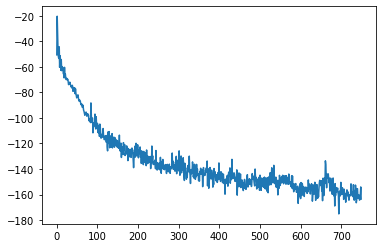

In [12]:
plt.plot(loss_history)

In [13]:
with torch.no_grad():
    zs = model.sample(1000)
    z = zs[-1]
    z = z.detach().numpy()

(-5.0, 100.0)

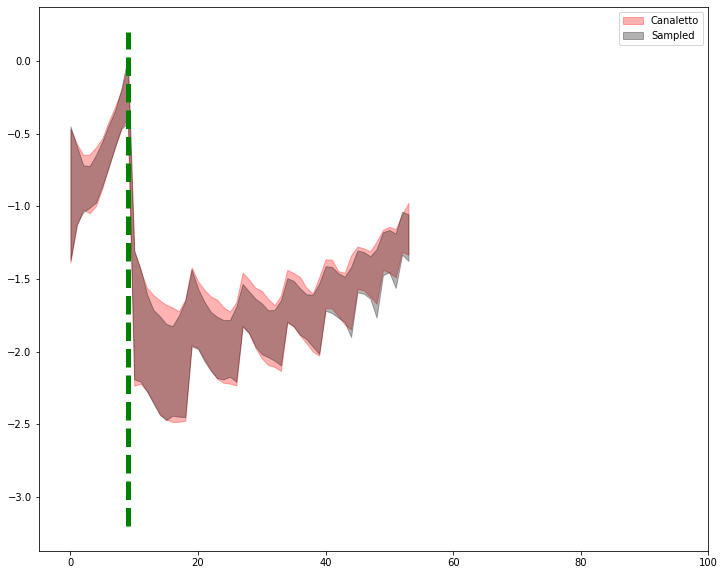

In [14]:

fig = plt.figure(figsize=(12, 10))

plt.fill_between(np.arange(X.shape[1]),\
                 np.percentile(X,2.5,axis=0),np.percentile(X,97.5,axis=0),\
                 alpha=0.3, label="Canaletto",color='red', )

plt.fill_between(np.arange(z.shape[1]),\
                 np.percentile(z,2.5,axis=0),np.percentile(z,97.5,axis=0),\
                 alpha=0.3, label="Sampled",color='k',)
plt.legend()

plt.plot([10 - 1, 10 - 1], [-3.2, 0.2], ls='--', lw=5, c='g')

plt.xlim(-5, 100)

In [15]:
zs, prior_logprob, log_det = model(X)

logprob = prior_logprob + log_det

In [16]:
# define network
X_test = data_follower
print(X_test.shape)

X_test = np.log10(X_test[:, :-1])

X_test = torch.Tensor(X_test)
print(X_test.shape)

zs, prior_logprob, log_det = model(X_test)

logprob1= prior_logprob + log_det

(40, 55)
torch.Size([40, 54])


In [17]:
X_test_can = np.log10(X_test_canaletto[:, :-1])

X_test_can = torch.Tensor(X_test_can)
X_test_can.size()

torch.Size([38, 54])

In [18]:
zs, prior_logprob, log_det = model(X_test_can)

logprob2= prior_logprob + log_det

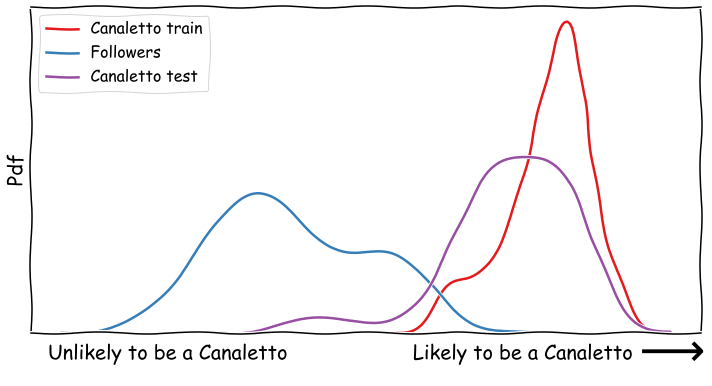

In [20]:
import seaborn as sns


a = sns.color_palette("Set1")
f, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(logprob.detach().numpy(), label='Canaletto train', ax=ax, color=a[0], lw=2.5)
sns.kdeplot(logprob1.detach().numpy(),  label='Followers', ax=ax, color=a[1],  lw=2.5)
sns.kdeplot(logprob2.detach().numpy(),  label='Canaletto test', ax=ax, lw=2.5, color=a[3])

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_yticks([])

ax.set_ylabel('Pdf', fontsize=20)
ax.text(0.025, -0.08, "Unlikely to be a Canaletto", transform=ax.transAxes, fontsize=20)
ax.text(0.57, -0.08, "Likely to be a Canaletto", transform=ax.transAxes, fontsize=20)

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_yticks([])
ax.legend(fontsize=16)
ax.text(0.895, -0.1, r'$ \longrightarrow$', transform=ax.transAxes, fontsize=46)

f.savefig('../../plot2.pdf', dpi=300)

Populating the interactive namespace from numpy and matplotlib


/Users/ioanaciuca/anaconda3/envs/moreDL/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


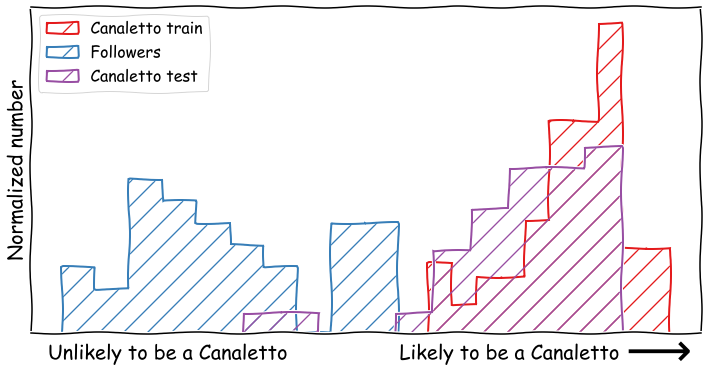

In [21]:
%pylab inline
plt.xkcd()

fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(logprob.detach().numpy(), color=a[0], label='Canaletto train', histtype='step', density=True, linewidth=2, hatch='/')
ax.hist(logprob1.detach().numpy(), color=a[1], label='Followers', histtype='step', density=True,  linewidth=2, hatch='/')
ax.hist(logprob2.detach().numpy(), color=a[3], label='Canaletto test', histtype='step', density=True, linewidth=2, hatch='/')

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_yticks([])

ax.set_ylabel('Normalized number', fontsize=20)
ax.text(0.025, -0.08, "Unlikely to be a Canaletto", transform=ax.transAxes, fontsize=20)
ax.text(0.55, -0.08, "Likely to be a Canaletto", transform=ax.transAxes, fontsize=20)

ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_xticks([])
ax.set_yticks([])
ax.legend(fontsize=16)
ax.text(0.875, -0.1, r'$ \longrightarrow$', transform=ax.transAxes, fontsize=46)

fig.savefig('../../plot1.pdf', dpi=300)

In [175]:
import umap

In [177]:
from sklearn.preprocessing import StandardScaler

(165, 55)


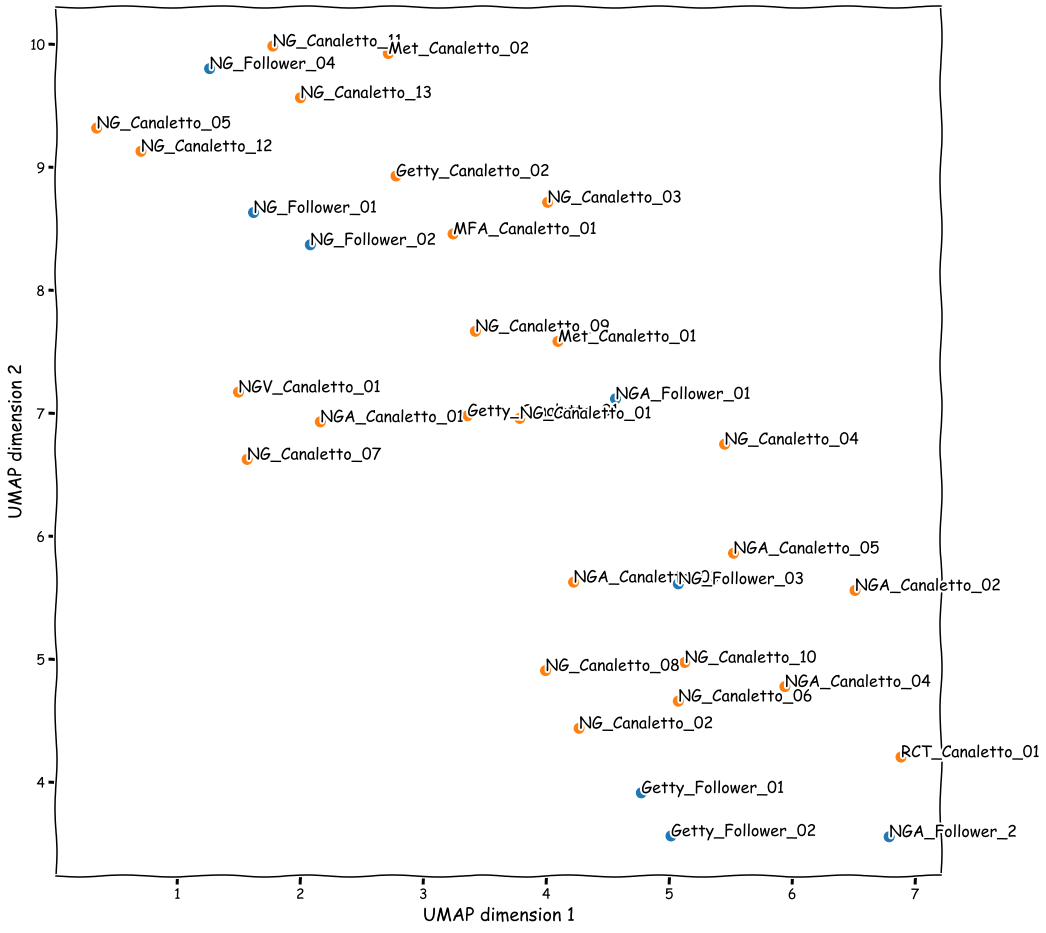

In [390]:
#emdedding = pd.read_csv('../cache/Canaletto/_umap_embedding.csv')
df_features = df.copy()
df_features = df_features.drop(
    ["class_labels", "target_names", "img_names"], axis=1
)
df_features.describe()

stcoeffs = df_features.to_numpy()
print(stcoeffs.shape)

stcoeffs = StandardScaler().fit_transform(stcoeffs)

reducer = umap.UMAP(n_neighbors=50, min_dist=0.2, n_components=2)
embd = reducer.fit_transform(stcoeffs)

embedding = pd.DataFrame()
for i in range(embd.shape[1]):
    embedding["Dim%d" % i] = embd[:, i]
embedding["img_names"] = df["img_names"].values




interp_filter =df["img_names"].str.startswith("interp")
df_interp = df[interp_filter]
labels = df_interp["class_labels"].values
names = df_interp["img_names"].values

clean_names = [x.replace("interp_", "") for x in names]
fig, ax = plt.subplots(figsize=(16, 16))
ax.set_aspect('equal')
fembd = embedding[interp_filter].reset_index()

ax.scatter(
    fembd["Dim0"],
    fembd["Dim1"],
    c=[sns.color_palette()[x] for x in labels],
    s=100,
)

for i, txt in enumerate(clean_names):
    ax.annotate(txt, (fembd["Dim0"][i], fembd["Dim1"][i]), fontsize=16)

ax.set_xlabel("UMAP dimension 1", fontsize=18)
ax.set_ylabel("UMAP dimension 2", fontsize=18)
# ax.set_xticklabels([])
# ax.set_yticklabels([])

plt.show()

##### 

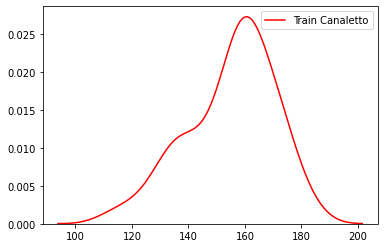

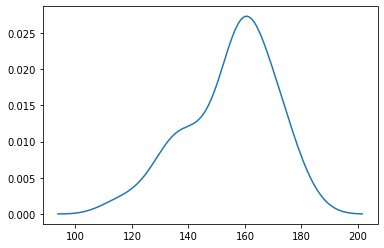

In [43]:
from seaborn import kdeplot

my_kde = kdeplot(logprob.detach().numpy(), color='r',  label='Train Canaletto')

line = my_kde.lines[0]
x, y = line.get_data()
fig, ax = plt.subplots()
ax.plot(x[x>0], y[x>0])

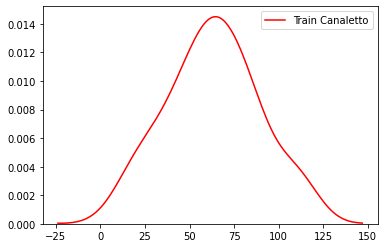

In [47]:
my_kde = kdeplot(logprob1.detach().numpy(), color='r',  label='Train Canaletto')

line = my_kde.lines[0]
x1, y1 = line.get_data()


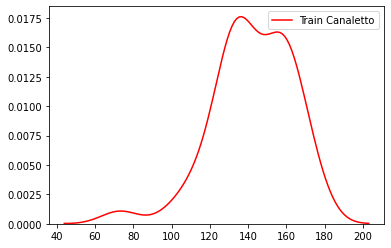

In [48]:
my_kde = kdeplot(logprob2.detach().numpy(), color='r',  label='Train Canaletto')

line = my_kde.lines[0]
x2, y2 = line.get_data()

## The final bit of the MVP. 

* retrain the full model with the canalettos
* get an idea of the probability

In [6]:
# define network
X_full = data_canaletto
print(X_full.shape)


X = np.log10(X_full[:, :-1])

X = torch.Tensor(X)
print(X.shape)

dim = X.shape[-1]
print('New dim after adding the labels is', dim)

# choose prior here
base_mu, base_cov = torch.zeros(dim).to(device), torch.eye(dim).to(device)
prior = MultivariateNormal(base_mu, base_cov)

# configure the normalising flow
nfs_flow = NSF_CL
nflows = 1
hidden_dim = 16 #50 dims here... probs neeed to increase


flows = [nfs_flow(dim=dim, device=device, K=8, B=3, hidden_dim=hidden_dim) for _ in range(nflows)] #things to change> maybe more is needed??!
convs = [Invertible1x1Conv(dim=dim, device=device) for _ in flows]
norms = [ActNorm(dim=dim, device=device) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# initialise the model
model = NormalizingFlowModel(prior, flows, device=device)

#if torch.cuda.device_count() >1:
#    print("Let's use", torch.cuda.device_count(), "GPUs!")
#    model = nn.DataParallel(model)

#assume this is de facto
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)  # todo tune WD
#print("number of params: ", sum(p.numel() for p in model.parameters()))

(125, 55)
torch.Size([125, 54])
New dim after adding the labels is 54


In [9]:
batch_size=20

oom = False
try:
    model, loss_history = run_model(batch_size)

except RuntimeError: # Out of memory
    oom = True
    print('Error!')

if oom:
    for _ in range(batch_size):
        model, loss_history = run_model(1)

Started training
Loss at step k = 0: -40.04266357421875
Loss at step k = 10: -96.1332778930664
Loss at step k = 20: -111.23966979980469
Loss at step k = 30: -124.56163024902344
Loss at step k = 40: -134.95462036132812
Loss at step k = 50: -138.6138153076172
Loss at step k = 60: -138.7165069580078
Loss at step k = 70: -135.05296325683594
Loss at step k = 80: -150.24752807617188
Loss at step k = 90: -147.16055297851562
Loss at step k = 100: -148.3780975341797
Loss at step k = 110: -155.53428649902344
Loss at step k = 120: -163.80001831054688
Loss at step k = 130: -154.12533569335938
Loss at step k = 140: -162.45619201660156
Elapsed time: 13.6 s


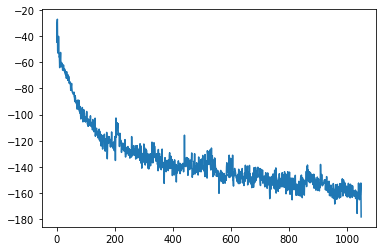

In [10]:
plt.plot(loss_history)

In [11]:
with torch.no_grad():
    zs = model.sample(1000)
    z = zs[-1]
    z = z.detach().numpy()

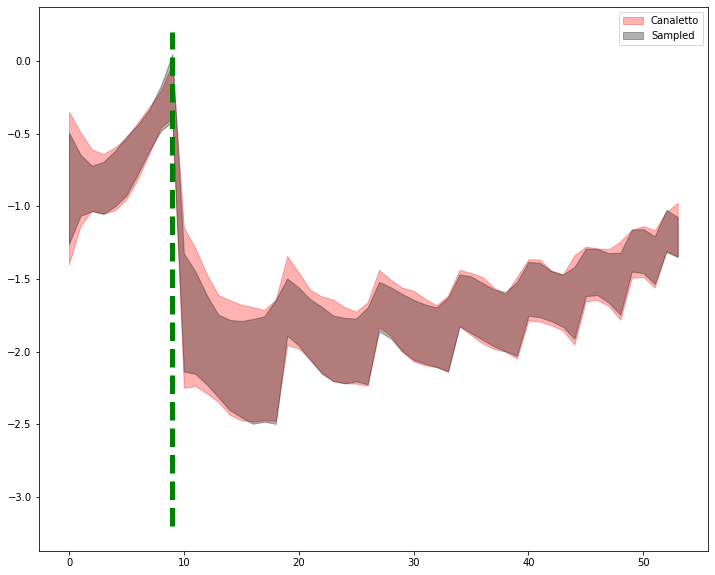

In [12]:
fig = plt.figure(figsize=(12, 10))

plt.fill_between(np.arange(X.shape[1]),\
                 np.percentile(X,2.5,axis=0),np.percentile(X,97.5,axis=0),\
                 alpha=0.3, label="Canaletto",color='red', )

plt.fill_between(np.arange(z.shape[1]),\
                 np.percentile(z,2.5,axis=0),np.percentile(z,97.5,axis=0),\
                 alpha=0.3, label="Sampled",color='k',)
plt.legend()

plt.plot([10 - 1, 10 - 1], [-3.2, 0.2], ls='--', lw=5, c='g')

In [34]:
X_test = data_follower
print(X_test.shape)

X_test = np.log10(X_test[:, :-1])

X_test = torch.Tensor(X_test)
print(X_test.shape)

zs, prior_logprob, log_det = model(X_test)

logprob_follower = prior_logprob + log_det

(40, 55)
torch.Size([40, 54])


In [35]:
zs, prior_logprob, log_det = model(X)

logprob_can= prior_logprob + log_det

<AxesSubplot:>

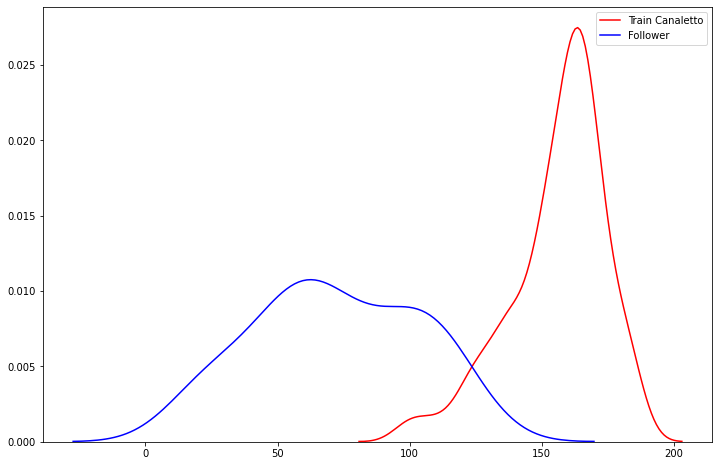

In [15]:
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(logprob_can.detach().numpy(), color='r',  label='Train Canaletto', ax=ax)
sns.kdeplot(logprob_follower.detach().numpy(), color='b',  label='Follower', ax=ax)


In [50]:
new_df = pd.read_csv('/Users/ioanaciuca/Desktop/hephaestusaiLight/cache/canaletto_test/reduced_l_scattering_fixed_pix_0_25mm10_4_2048_df_rgb0.csv')

In [51]:
new_df

,Coeff_0,Coeff_1,Coeff_2,Coeff_3,Coeff_4,Coeff_5,Coeff_6,Coeff_7,Coeff_8,Coeff_9,...,Coeff_48,Coeff_49,Coeff_50,Coeff_51,Coeff_52,Coeff_53,Coeff_54,target_names,class_labels,img_names
0,0.203805,0.133408,0.099005,0.089156,0.100055,0.132325,0.196162,0.309565,0.495394,0.838069,...,0.021466,0.046579,0.047796,0.034992,0.072939,0.057182,0.077774,Not_canaletto_test,1,interp_NGA_Canaletto_05
1,0.189726,0.176894,0.171328,0.162743,0.165512,0.188109,0.243379,0.360634,0.567973,0.922159,...,0.024758,0.050449,0.046147,0.036376,0.073158,0.063311,0.096823,Not_canaletto_test,1,interp_X_Canaletto


In [52]:
df_new = new_df[new_df['class_labels'] == 1]
df_new



feat_data_new = df_new.drop(['class_labels', 'target_names', 'img_names'], axis=1)


data_new = feat_data_new.to_numpy()


In [60]:
new_df

,Coeff_0,Coeff_1,Coeff_2,Coeff_3,Coeff_4,Coeff_5,Coeff_6,Coeff_7,Coeff_8,Coeff_9,...,Coeff_48,Coeff_49,Coeff_50,Coeff_51,Coeff_52,Coeff_53,Coeff_54,target_names,class_labels,img_names
0,0.203805,0.133408,0.099005,0.089156,0.100055,0.132325,0.196162,0.309565,0.495394,0.838069,...,0.021466,0.046579,0.047796,0.034992,0.072939,0.057182,0.077774,Not_canaletto_test,1,interp_NGA_Canaletto_05
1,0.189726,0.176894,0.171328,0.162743,0.165512,0.188109,0.243379,0.360634,0.567973,0.922159,...,0.024758,0.050449,0.046147,0.036376,0.073158,0.063311,0.096823,Not_canaletto_test,1,interp_X_Canaletto


In [53]:
X_new = data_new
print(X_new.shape)


(2, 55)


In [54]:
data_new

array([[0.20380509, 0.133408  , 0.09900471, 0.08915624, 0.10005536,
        0.13232525, 0.19616163, 0.30956454, 0.495394  , 0.83806869,
        0.03011641, 0.02334567, 0.01659539, 0.01210688, 0.01004322,
        0.00941667, 0.0091297 , 0.00926583, 0.00920293, 0.01888342,
        0.01507938, 0.01144877, 0.00945903, 0.00859164, 0.00790276,
        0.00760307, 0.00745713, 0.01541336, 0.01356717, 0.01160955,
        0.0104974 , 0.00957695, 0.00886888, 0.00819741, 0.01579914,
        0.01524546, 0.01410668, 0.01308716, 0.01194513, 0.01053582,
        0.01994773, 0.02044488, 0.01937647, 0.01779366, 0.01486358,
        0.0288639 , 0.03014395, 0.02803228, 0.02146648, 0.04657875,
        0.04779579, 0.03499197, 0.07293866, 0.05718173, 0.07777418],
       [0.18972576, 0.17689449, 0.17132836, 0.16274312, 0.16551218,
        0.1881087 , 0.24337886, 0.36063414, 0.56797256, 0.92215901,
        0.02944036, 0.0250963 , 0.0194916 , 0.01541168, 0.01308879,
        0.01174102, 0.01121982, 0.01242734, 0.0

In [55]:

X_new = np.log10(X_new[:, :-1])

X_new = torch.Tensor(X_new)
print(X_new.shape)

zs, prior_logprob, log_det = model(X_new)

logprob_new = prior_logprob + log_det

torch.Size([2, 54])


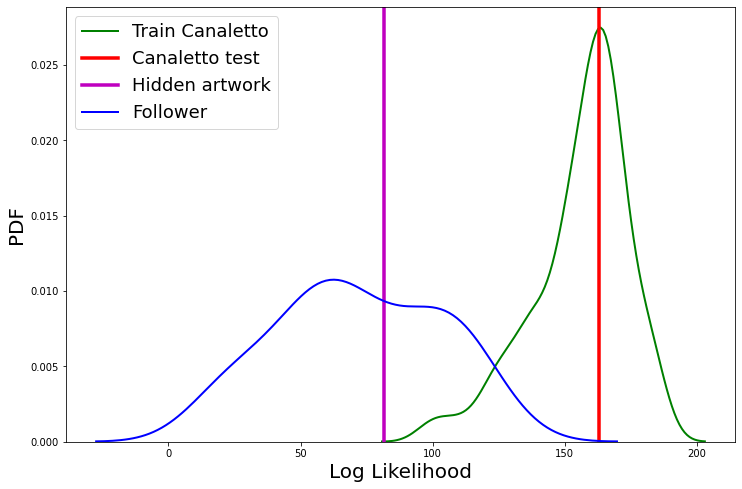

In [61]:
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 8))
sns.kdeplot(logprob_can.detach().numpy(), color='g', lw=2.0, label='Train Canaletto', ax=ax)
ax.axvline(x=logprob_new.detach().numpy()[0], color='r', lw=3.5, label='Canaletto test')
ax.axvline(x=logprob_new.detach().numpy()[1], color='m', lw=3.5, label='Hidden artwork')

sns.kdeplot(logprob_follower.detach().numpy(), color='b', lw=2.0,  label='Follower', ax=ax)
plt.legend(fontsize=18)

plt.xlabel('Log Likelihood', fontsize=20)
plt.ylabel('PDF', fontsize=20)

plt.savefig('hidden.png', dpi = 200)

In [32]:
logprob_new[1]


tensor(12.5536, grad_fn=<SelectBackward>)

In [40]:
X.shape

torch.Size([125, 54])

In [54]:
logprob_test = max(logprob_follower)
print(logprob_test)

tensor(109.3000, grad_fn=<UnbindBackward>)


In [104]:
n_samples = 10000

with torch.no_grad():
    zs = model.sample(n_samples)
    z = zs[-1]
    z = z.detach().numpy()

In [105]:
zs, prior_logprob, log_det = model(torch.Tensor(z))

logprob_samples = prior_logprob + log_det

(array([3.000e+00, 8.000e+00, 2.700e+01, 9.200e+01, 3.170e+02, 1.208e+03,
        3.038e+03, 3.818e+03, 1.412e+03, 7.700e+01]),
 array([ 81.34483 ,  91.655624, 101.96641 , 112.2772  , 122.58798 ,
        132.89877 , 143.20956 , 153.52036 , 163.83113 , 174.14192 ,
        184.45271 ], dtype=float32),
 <BarContainer object of 10 artists>)

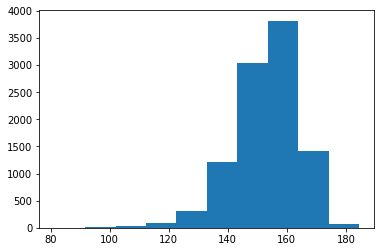

In [106]:
plt.hist(logprob_samples.detach().numpy())

In [107]:
k = 0

for i in logprob_samples:
    if i < logprob_test.item():
        k = k + 1

In [108]:
k

26

In [110]:
prob = (k/ n_samples) 
prob

0.0026

In [112]:
df_follower

,Coeff_0,Coeff_1,Coeff_2,Coeff_3,Coeff_4,Coeff_5,Coeff_6,Coeff_7,Coeff_8,Coeff_9,...,Coeff_48,Coeff_49,Coeff_50,Coeff_51,Coeff_52,Coeff_53,Coeff_54,target_names,class_labels,img_names
1,0.115522,0.129388,0.126162,0.135942,0.153372,0.175926,0.203529,0.241823,0.289705,0.342497,...,0.022101,0.035465,0.033289,0.028118,0.042365,0.039134,0.049495,Not_canaletto,0,ShiftScaleRotate_Getty_Follower_01
3,0.240860,0.187453,0.170235,0.183516,0.217094,0.264668,0.321244,0.412957,0.582707,0.804874,...,0.029364,0.057599,0.052348,0.036298,0.074440,0.060162,0.094230,Not_canaletto,0,interp_NG_Follower_01
5,0.064093,0.096723,0.108781,0.118515,0.141725,0.184554,0.250192,0.362707,0.555805,0.762979,...,0.031231,0.053865,0.054362,0.045838,0.079485,0.072763,0.112376,Not_canaletto,0,ShiftScaleRotate_NGA_Follower_01
10,0.164686,0.153721,0.126342,0.115292,0.119597,0.143159,0.187710,0.253209,0.315162,0.378051,...,0.021048,0.036222,0.035266,0.031103,0.047658,0.046718,0.055155,Not_canaletto,0,Transpose_Getty_Follower_02
17,0.259845,0.225694,0.210001,0.201924,0.213336,0.247586,0.310680,0.409528,0.578471,0.811662,...,0.043998,0.056560,0.053108,0.053469,0.072503,0.071682,0.095890,Not_canaletto,0,Transpose_NG_Follower_04
18,0.240860,0.187453,0.170235,0.183516,0.217094,0.264668,0.321243,0.412958,0.582703,0.804881,...,0.029365,0.057599,0.052348,0.036299,0.074440,0.060161,0.094232,Not_canaletto,0,Transpose_NG_Follower_01
20,0.228654,0.178315,0.155503,0.163104,0.192051,0.237549,0.303852,0.417579,0.598172,0.844699,...,0.034360,0.059119,0.057005,0.046784,0.092236,0.076160,0.097403,Not_canaletto,0,VerticalFlip_NG_Follower_01
21,0.175055,0.187573,0.184826,0.203234,0.239649,0.289992,0.370200,0.506658,0.680202,0.804608,...,0.036100,0.068005,0.064695,0.044762,0.094518,0.071792,0.105623,Not_canaletto,0,ShiftScaleRotate_NG_Follower_01
23,0.138997,0.093719,0.075901,0.073172,0.083816,0.107162,0.145959,0.200083,0.284903,0.383560,...,0.017706,0.028971,0.028469,0.026781,0.038906,0.040445,0.055291,Not_canaletto,0,interp_NGA_Follower_2
31,0.239757,0.187233,0.170869,0.186312,0.222016,0.271122,0.325256,0.412852,0.589196,0.825922,...,0.030696,0.057247,0.052504,0.036764,0.075200,0.060458,0.092962,Not_canaletto,0,HorizontalFlip_NG_Follower_01


In [116]:
ss = logprob_follower.detach().numpy()

idx =np.where(ss == max(ss))[0]
idx

array([2])

In [118]:
df_follower.iloc[2]

Coeff_0                                0.0640926
Coeff_1                                0.0967231
Coeff_2                                 0.108781
Coeff_3                                 0.118515
Coeff_4                                 0.141725
Coeff_5                                 0.184554
Coeff_6                                 0.250192
Coeff_7                                 0.362707
Coeff_8                                 0.555805
Coeff_9                                 0.762979
Coeff_10                              0.00925585
Coeff_11                              0.00823756
Coeff_12                              0.00660365
Coeff_13                              0.00557173
Coeff_14                              0.00513184
Coeff_15                              0.00497733
Coeff_16                              0.00523682
Coeff_17                              0.00613618
Coeff_18                              0.00644358
Coeff_19                               0.0141417
Coeff_20            

In [ ]:
df_copy = df.copy()

for i in range(len(df_copy)):
    
    if df_copy['target_names'][i] == "Not_canaletto":
        df_copy['class_labels'][i] = 0

df_copy

df_copy.to_csv('/Users/ioanaciuca/Desktop/hephaestusaiLight/cache/Canaletto/reduced_l_scattering_fixed_pix_0_25mm10_4_2048_df_rgb0.csv', index=False)

In [ ]:
from astropy.stats import bayesian_blocks as bb


fig = plt.figure(figsize=(8, 8))

edges= bb(logprob.detach().numpy(), fitness='events', p0=0.001)
plt.hist(logprob.detach().numpy(), bins=edges, density=True, alpha=1.0, color='r', histtype='step', lw=2, label='Train Canaletto')


edges1= bb(logprob1.detach().numpy(), fitness='events', p0=0.001)
plt.hist(logprob1.detach().numpy(), bins=edges1, density=True, alpha=1.0, color='b', histtype='step', lw=2, label='Follower')

edges2= bb(logprob2.detach().numpy(), fitness='events', p0=0.001)
plt.hist(logprob2.detach().numpy(), bins=edges2, density=True, alpha=1.0, color='m', histtype='step', lw=2, label='Test Canaletto')






plt.legend(fontsize=16)

In [ ]:
def plot_scattering_estimates(df):

    df_not_artist = df[df["class_labels"] == 1]
    df_artist = df[df["class_labels"] == 0]

    feat_data_not_artist = df_not_artist.drop(
        ["class_labels", "target_names", "img_names"], axis=1
    )
    feat_data_artist = df_artist.drop(
        ["class_labels", "target_names", "img_names"], axis=1
    )

    data_not_artist = feat_data_not_artist.to_numpy()
    data_artist = feat_data_artist.to_numpy()

    # -------------------------------------------------------------------------------------------------------
    # restore coefficients
    scattering_coeff_array_not_artist = data_not_artist
    scattering_coeff_array_not_artist = np.log10(scattering_coeff_array_not_artist)
    # plot 68, 95 confidence level

    scattering_coeff_array_artist = data_artist
    scattering_coeff_array_artist = np.log10(scattering_coeff_array_artist)

    fig = plt.figure(figsize=(10, 8))

    plt.fill_between(
        np.arange(scattering_coeff_array_not_artist.shape[1]),
        np.percentile(scattering_coeff_array_not_artist, 2.5, axis=0),
        np.percentile(scattering_coeff_array_not_artist, 97.5, axis=0),
        alpha=0.5,
        label="Not" + str('artist'),
        color="blue",
    )

    plt.fill_between(
        np.arange(scattering_coeff_array_artist.shape[1]),
        np.percentile(scattering_coeff_array_artist, 2.5, axis=0),
        np.percentile(scattering_coeff_array_artist, 97.5, axis=0),
        alpha=0.5,
        label=str('artist'),
        color="m",
    )

    # plot delimiter
    # plt.plot(
    #     [self.config["J"] - 1, self.config["J"] - 1], [-3.2, 0.2], ls="--", lw=5, color="black"
    # )

    plt.plot([9, 9], [-3.2, 0.2], ls='--', color='g', lw=5)
    plt.text(0, -0.1, "Strokes")
    plt.text(11.0, -0.1, "Clustering of Strokes")
    plt.xlim([-5, len(df.iloc[0, :]) + 5])

    plt.ylabel("Estimate")
    plt.xlabel("Statistical Descriptors")
    plt.legend(loc=4)

    plt.show()

In [ ]:
plot_scattering_estimates(df_test)

In [ ]:
df_copy.shape

In [ ]:
from alibi.explainers import KernelShap
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
target = df.class_labels.to_numpy() #class labels

target_names = df.target_names.to_list() #name
feat_data = df.drop(['class_labels', 'target_names', 'img_names'], axis=1)
feature_names  = feat_data.columns.to_list()

data = feat_data.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.7, 
                                                    random_state=0,
                                                   )
print("Training records: {}".format(X_train.shape[0]))
print("Testing records: {}".format(X_test.shape[0]))

scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)



In [ ]:
df.head(20)

In [ ]:
data

In [ ]:
y_test

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF
clf =GaussianProcessClassifier(1*Matern(2))
clf.fit(X_train_norm, y_train)
pred = clf.predict(X_test_norm)
pred

In [ ]:
y_test

In [ ]:
np.random.seed(0)


y_pred = clf.predict(X_test_norm)
cm = confusion_matrix(y_test, y_pred)
title = 'Confusion matrix for GP Classifier'
disp = plot_confusion_matrix(clf, 
                             X_test_norm, 
                             y_test,
                             #display_labels=target_names,
                             cmap=plt.cm.Blues,
                             normalize=None
                            )
disp.ax_.set_title(title)

In [ ]:

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
title = 'Confusion matrix for GP Classifier'
disp = plot_confusion_matrix(clf, 
                             X_train_norm, 
                             y_train,
       
                             cmap=plt.cm.Blues,
                             normalize=None
                            )
disp.ax_.set_title(title)

In [ ]:
y_train

In [ ]:
y_train_norm

In [ ]:
import os
import sys
import itertools
sys.path.append('/Users/ioanaciuca/Desktop/Normalizing_flows/DeepSpectra/')

import torch.optim as optim

from nflib.spline_flows import NSF_CL
from nflib.flows import (
    AffineConstantFlow,
    ActNorm,
    Invertible1x1Conv,
    NormalizingFlow,
    NormalizingFlowModel,
)

device='cpu'

dim = X.shape[-1]
print('New dim after adding the labels is', dim)

# choose prior here
base_mu, base_cov = torch.zeros(dim).to(device), torch.eye(dim).to(device)
prior = MultivariateNormal(base_mu, base_cov)

# configure the normalising flow
nfs_flow = NSF_CL
nflows = 1
hidden_dim = 16 #50 dims here... probs neeed to increase


flows = [nfs_flow(dim=dim, device=device, K=8, B=3, hidden_dim=hidden_dim) for _ in range(nflows)] #things to change> maybe more is needed??!
convs = [Invertible1x1Conv(dim=dim, device=device) for _ in flows]
norms = [ActNorm(dim=dim, device=device) for _ in flows]
flows = list(itertools.chain(*zip(norms, convs, flows)))

# initialise the model
model = NormalizingFlowModel(prior, flows, device=device)

#if torch.cuda.device_count() >1:
#    print("Let's use", torch.cuda.device_count(), "GPUs!")
#    model = nn.DataParallel(model)

#assume this is de facto
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)  # todo tune WD
#print("number of params: ", sum(p.numel() for p in model.parameters()))


batch_size=20

oom = False
try:
    model, loss_history = run_model(batch_size)

except RuntimeError: # Out of memory
    oom = True
    print('Error!')

if oom:
    for _ in range(batch_size):
        model, loss_history = run_model(1)

> Real NVP stuff

In [ ]:
#define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, z):
        x = self.g(z)
        return x
    
device = torch.device("cpu")
num_neurons = 32

# input dimension
dim_in = X.shape[-1]

nets = lambda: nn.Sequential(nn.Linear(dim_in, num_neurons), nn.LeakyReLU(),\
                             nn.Linear(num_neurons, num_neurons), nn.LeakyReLU(),\
                             nn.Linear(num_neurons, dim_in), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(dim_in, num_neurons), nn.LeakyReLU(),\
                             nn.Linear(num_neurons, num_neurons), nn.LeakyReLU(),\
                             nn.Linear(num_neurons, dim_in))

# define mask
num_layers = 10
masks = []
for i in range(num_layers):
    mask_layer = np.random.randint(2,size=(dim_in))
    masks.append(mask_layer)
    masks.append(1-mask_layer)
masks = torch.from_numpy(np.array(masks).astype(np.float32))
masks.to(device)

# set prior
prior = distributions.MultivariateNormal(torch.zeros(dim_in, device=device),\
                                         torch.eye(dim_in, device=device))

# intiate flow
flow = RealNVP(nets, nett, masks, prior)

num_epochs = 100
batch_size = 20

# break into batches
nsamples = X.shape[0]
nbatches = nsamples // batch_size

# optimizing flow models
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-5)
print("number of params: ", sum(p.numel() for p in flow.parameters()))

# train the network
# put here the loss
loss_history = []
for e in range(num_epochs):

    # randomly permute the data
    perm = torch.randperm(nsamples)

    # For each batch, calculate the gradient with respect to the loss and take
    # one step.
    for i in range(nbatches):
        idx = perm[i * batch_size : (i+1) * batch_size]
        loss = -flow.log_prob(X[idx]).mean()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        loss_history.append(loss)

    # the average loss.
    if e % 10 == 0:
        print('iter %s:' % e, 'loss = %.3f' % loss)
        
plt.plot(loss_history, label = 'Negative log likelihood')
plt.title("Model Loss vs Training Iteration")
plt.xlabel('Training Iteration')
plt.ylabel('Loss')
plt.show()

In [ ]:
dim_in = 54

base_mu, base_cov = torch.zeros(dim_in), torch.eye(dim_in)
base_dist = MultivariateNormal(base_mu, base_cov)
Z = base_dist.rsample(sample_shape=(1000,))

samples = flow.sample(Z)

samples = samples.detach().numpy()

plt.fill_between(np.arange(samples.shape[1]),\
                 np.percentile(X,2.5,axis=0),np.percentile(samples,97.5,axis=0),\
                 alpha=0.3, label="Canaletto",color='blue')

# plot delimiter
plt.plot([10-1,10-1], [-3.2,0.2], ls="--", lw=5, color="black")
plt.text(-11.,-0.1, "Strokes")
plt.text(11.,-0.1, "Clustering of Strokes")
plt.xlim([-15,60])